# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, the pipeline for a traffic sign classifier is implemented. The implementation is divided into six steps:

* Loading the data
* Dataset Summary & Exploration
* Augmenting and Pre-processing the Dataset
* Designing and Testing Neural Network Model Architectures
* Testing the NN model on new images
* Visualize the Neural Network's State with Test Images

---
## Step 1: Load The Data

In [1]:
# Load pickled data
import pickle

#loading data set, not available in the github repository due to size constraints, Check README and/or Writeup
training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### A Basic Summary of the Data Set Using Python and Numpy

In [2]:
import numpy as np 

#Number of training examples
n_train = len(X_train)

#Number of validation examples
n_validation = len(X_valid)

#Number of testing examples.
n_test = len(X_test)

#the shape of an traffic sign image
image_shape = X_test[0].shape

#number of unique classes/labels there are in the dataset.
n_classes = np.amax([np.amax(y_train), np.amax(y_valid), np.amax(y_test)]) - np.amin([np.amin(y_train), np.amin(y_valid), np.amin(y_test)]) + 1


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

In [3]:
### Data exploration visualization
import matplotlib.pyplot as plt
import random
import math 

n_visualize = 9 #number of images to be plotted
n_columns = 3 #number of columns in the figure
n_rows = math.ceil(n_visualize/n_columns) #number of rows in the figure

plt.figure(figsize=(15,15))
plt.suptitle('Training set samples', fontsize=16)

for i in range(n_visualize):
    index = random.randint(0,n_train-1)
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(X_train[index])
    plt.title(('image:'+ str(index) +', label = ' + str(y_train[index])))

    
# Visualizations will be shown in the notebook.
#%matplotlib inline
plt.subplots_adjust(top=0.95)
plt.savefig('writeup_images/sample_data.jpg')
plt.show()

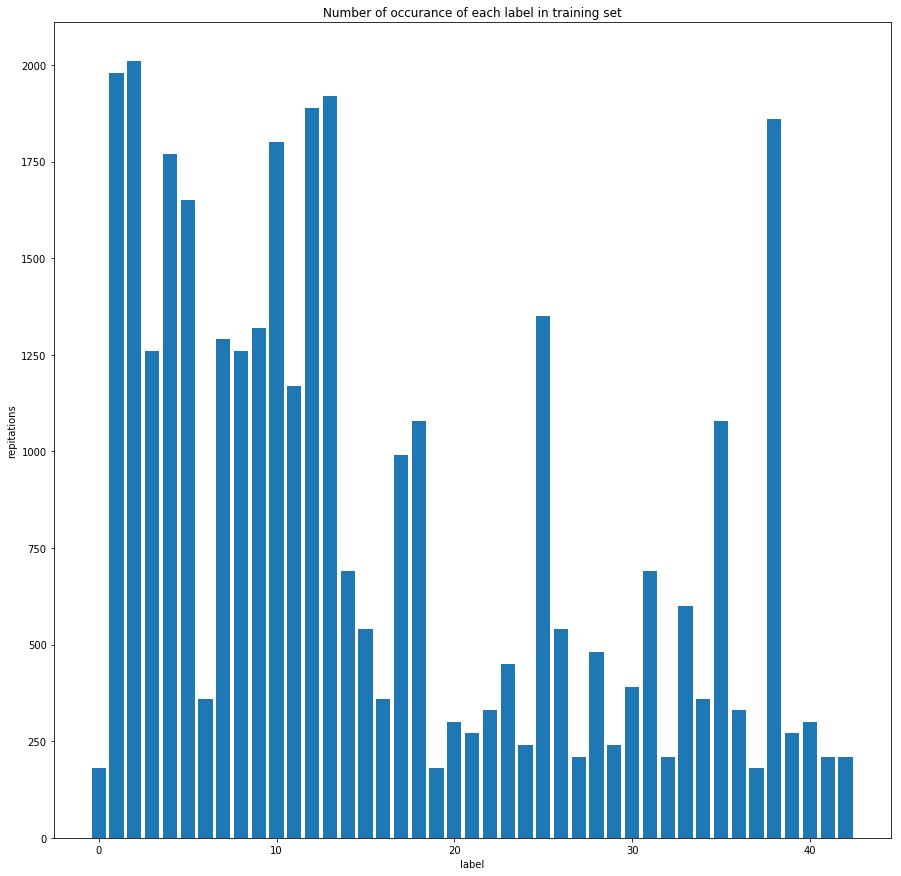

In [4]:
#show number of examples for each label in training set
labelCounter = [0] * n_classes

for i in range(n_train):
    labelCounter[y_train[i]] += 1

plt.figure(figsize=(15,15))
plt.bar(range(n_classes), labelCounter)
plt.title('Number of occurance of each label in training set')
plt.xlabel('label')
plt.ylabel('repitations')

plt.savefig('writeup_images/training_set_bar.jpg')
plt.show()

## Step 3: Augmenting and Pre-processing the Dataset

Prior to building a the deep learning architecture, certain changes are applied to the dataset that can yield better overall results and performance for the pipeline. Three methods are utilized: `Data Augmentation`, `Normalization` and `Grayscaling`. 

### Data Augmentation

The previous step/section shows a huge variation in the representation of certain labels/classes in the Dataset, as some labels are much more occur much more than others. This can negatively affect the performance of the pipeline. To undermine this problem, Data augmentation is applied to ensure a more balanced representation of labels. Augmentation is applied in three methods: `perspective transform`, `Image Translation` and `Image Rotation`.

In [5]:
#Applying data augmentation 
import image_edit

aug_min = 600 #minimum number of samples for each label
n_aug = 20 #number of augmented editions to each label if they exceed the minimum


#list for the indices of original image and the augmented version
org2aug_index = []

for i in range(n_classes):
    #creating augmented versions
    #if the label has low number of samples
    while(labelCounter[i] < aug_min):
        indices = []
        indices = np.where(y_train==i)[0]
        index2aug = random.choice(indices)
        img2aug = X_train[index2aug]
        X_train = np.insert(X_train, n_train, image_edit.augment_img(img2aug), axis=0)
        y_train = np.insert(y_train, n_train, i, axis=0)
        org2aug_index.append([index2aug, n_train])
        labelCounter[i] += 1
        n_train += 1  
    else:
        #create some augmented versions even for labels with a lot of samples
        for j in range(n_aug):
            indices = []
            indices = np.where(y_train==i)[0]
            index2aug = random.choice(indices)
            img2aug = X_train[index2aug]
            X_train = np.insert(X_train, n_train, image_edit.augment_img(img2aug), axis=0)
            y_train = np.insert(y_train, n_train, i, axis=0)
            org2aug_index.append([index2aug, n_train])
            labelCounter[i] += 1
            n_train += 1   


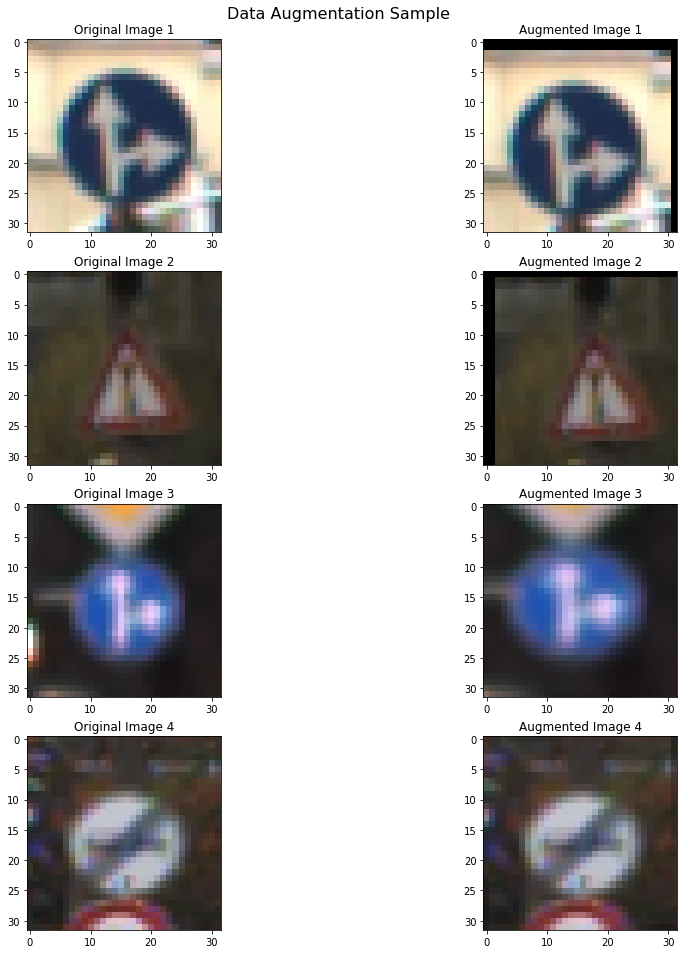

In [6]:
#Show random samples of original training set images and augmented versions

plt.figure(figsize=(15,15))
plt.suptitle('Data Augmentation Sample', fontsize=16)

#number of original/augmented samples to show
n_show = 4

for i in range(n_show):
    #obtain random original and augmented image
    index = random.randint(0,len(org2aug_index)-1)
    org2aug = org2aug_index[index]
    org_img = X_train[org2aug[0]]
    aug_img = X_train[org2aug[1]]
    
    #show the images
    plt.subplot(n_show,2, (2*i)+1)
    plt.imshow(org_img)
    plt.title('Original Image {}'.format(i+1))
    plt.subplot(n_show,2, (2*i)+2)
    plt.imshow(aug_img)
    plt.title('Augmented Image {}'.format(i+1))
    
plt.subplots_adjust(top=0.95)
plt.savefig('writeup_images/data_aug_sample.jpg')
plt.show()    

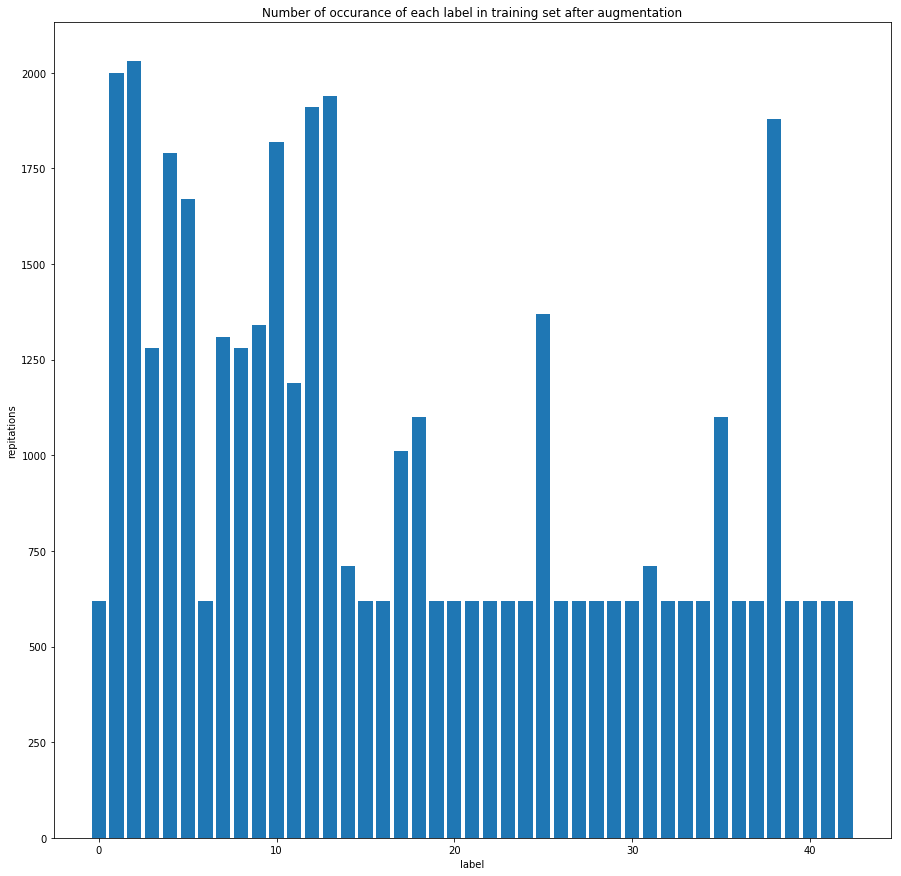

In [7]:
#show number of examples for each label in training set after augmentation
labelCounter = [0] * n_classes

for i in range(n_train):
    labelCounter[y_train[i]] += 1

plt.figure(figsize=(15,15))
plt.bar(range(n_classes), labelCounter)
plt.title('Number of occurance of each label in training set after augmentation')
plt.xlabel('label')
plt.ylabel('repitations')

plt.savefig('writeup_images/training_augmented_set_bar.jpg')
plt.show()

### Pre-process the Data Set (normalization and grayscale)

Two pre-processing methods are applied to the data set. First is grayscaling by converting images from rgb to grayscale. The second mehtod is normalization so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and is used in this project. 

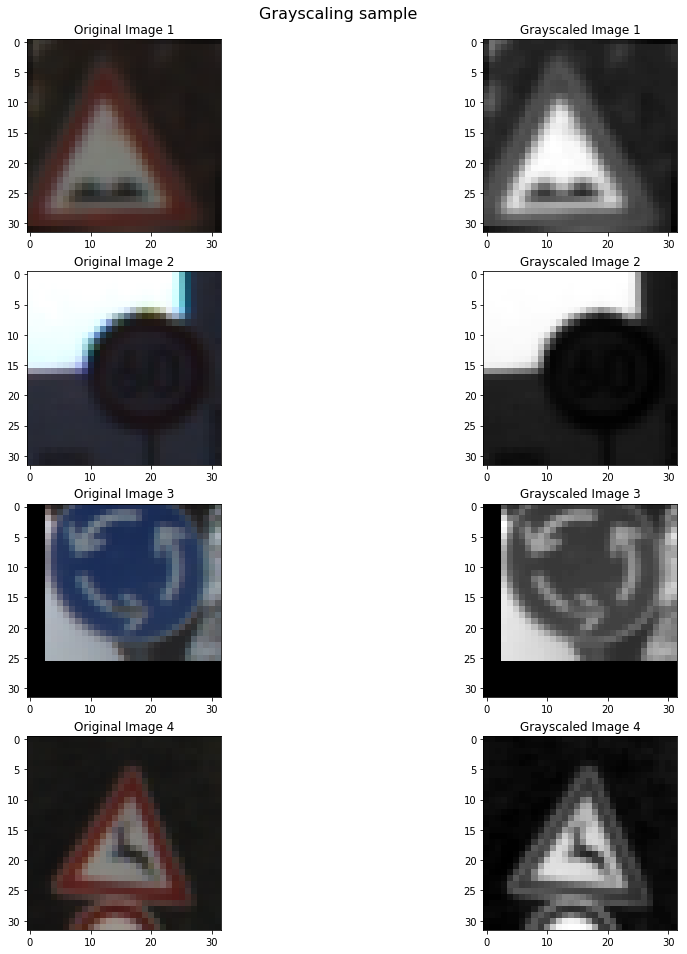

In [8]:
#Show Grayscaling samples
from image_edit import rgb2gray

plt.figure(figsize=(15,15))
plt.suptitle('Grayscaling sample', fontsize=16)

#number of original/grayscales samples to show
n_show = 4

for i in range(n_show):
    #obtain random image
    index = random.randint(0,n_train-1)
    img = X_train[index]
    
    #show the original/grayscaled images
    plt.subplot(n_show,2, (2*i)+1)
    plt.imshow(img)
    plt.title('Original Image {}'.format(i+1))
    plt.subplot(n_show,2, (2*i)+2)
    #print(rgb2gray([img])[0][:,:,0].shape)
    plt.imshow(rgb2gray([img])[0][:,:,0], cmap='gray')
    plt.title('Grayscaled Image {}'.format(i+1))

plt.subplots_adjust(top=0.95)
plt.savefig('writeup_images/data_gray_sample.jpg')
plt.show()   

In [9]:
### Preprocess the data here. 
from image_edit import rgb2gray, normalize

#shuffling the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)

#normalizing and grayscaling data
X_train_n = normalize(rgb2gray(X_train))
X_valid_n = normalize(rgb2gray(X_valid))
X_test_n = normalize(rgb2gray(X_test))
    
image_shape = X_train_n[0].shape

C:\Users\user\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


----

## Step 2: Design and Test a Neural Network Model Architecture

The deep learning model is implemented in this step. The NN model is Trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

First, The LeNet-5 CNN was implemented as a benchmark. With the LeNet-5 solution from the lecture, a validation set accuracy of about 0.89. Howeever, this project's [rubric](https://review.udacity.com/#!/rubrics/481/view) requires a validation set of atleast 0.93.

Therefore, a different architecture inspired by the one described in this [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) was adopted.

This notebook however still contains both architectures for future testing.

### Model Architecture

In [10]:
#tensorflow setup
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

In [11]:
### Defining the first architecture here.
#####LeNet architecture
###### Note: The LeNet architecture is slightly modified here 
###### by adding dropout functionality to the fully connvected layers

from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    inheight, inwidth, inchannels = image_shape
        
    #Layer 1: Convolutional. Input = image. Output = 28x28x6.
    wc1height = inheight - 28 + 1
    wc1width = inwidth - 28 + 1
    wc1 = tf.Variable(tf.truncated_normal([wc1height, wc1width, inchannels, 6], dtype=tf.float32, mean=mu, stddev=sigma),\
                      name='LeNet-wc1')
    bc1 = tf.Variable(tf.zeros([6], dtype=tf.float32), name='LeNet-bc1')
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    out_layer1 = tf.nn.bias_add(tf.nn.conv2d(x, wc1, strides, padding), bc1, name='LeNet-out_layer1')
    
    #Activation.
    out_layer1 = tf.nn.relu(out_layer1, name='LeNet-out_layer1-relu')
    
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    out_layer1 = tf.nn.max_pool(out_layer1, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='LeNet-out_layer1-pool')
    
    #Layer 2: Convolutional. Output = 10x10x16.
    wc2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], dtype=tf.float32, mean=mu, stddev=sigma), name='LeNet-wc2')
    bc2 = tf.Variable(tf.zeros([16], dtype=tf.float32), name='LeNet-bc2')
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    out_layer2 = tf.nn.bias_add(tf.nn.conv2d(out_layer1, wc2, strides, padding), bc2, name='LeNet-out_layer2')
    
    #Activation.
    out_layer2 = tf.nn.relu(out_layer2, name='LeNet-out_layer2-relu')
    
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    out_layer2 = tf.nn.max_pool(out_layer2, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='LeNet-out_layer2-pool')

    #Flatten. Input = 5x5x16. Output = 400.
    out_conv_layers = flatten(out_layer2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    wf1 = tf.Variable(tf.truncated_normal([400, 120], dtype=tf.float32, mean=mu, stddev=sigma), name='LeNet-wf1')
    bf1 = tf.Variable(tf.zeros([120], dtype=tf.float32), name='LeNet-bf1')
    out_layer3 = tf.add(tf.matmul(out_conv_layers, wf1), bf1, name='LeNet-out_layer3')
    
    #Activation.
    out_layer3 = tf.nn.relu(out_layer3, name='LeNet-out_layer3-relu')
    
    #Dropout
    out_layer3 = tf.nn.dropout(out_layer3, keep_prob, name='LeNet-out_layer3-dropout')
    
    
    #Layer 4: Fully Connected. Input = 120. Output = 84.
    wf2 = tf.Variable(tf.truncated_normal([120, 84], dtype=tf.float32, mean=mu, stddev=sigma), name='LeNet-wf2')
    bf2 = tf.Variable(tf.zeros([84], dtype=tf.float32), name='LeNet-bf2')
    out_layer4 = tf.add(tf.matmul(out_layer3, wf2), bf2, name='LeNet-out_layer4')
    
    #Activation.
    out_layer4 = tf.nn.relu(out_layer4, name='LeNet-out_layer4-relu')
    
    #Droput
    out_layer4 = tf.nn.dropout(out_layer4, keep_prob, name='LeNet-out_layer4-dropout')
    
    #Layer 5: Fully Connected. Input = 84. Output = n_classes.
    wf3 = tf.Variable(tf.truncated_normal([84, n_classes], dtype=tf.float32, mean=mu, stddev=sigma), name='LeNet-wf3')
    bf3 = tf.Variable(tf.zeros([n_classes], dtype=tf.float32), name='LeNet-bf3')
    logits = tf.add(tf.matmul(out_layer4, wf3), bf3, name='logits_out')
    
    return logits

In [12]:
### Defining the second architecture here.
#####This architecture is sumilar consists of two convolutional layers 
#####whose output is feed to a two stage fully connected layer
#####in a smilar approach to the one described in 
##### "http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf"

from tensorflow.contrib.layers import flatten

def s2_Covnet(x, keep_prob):  
    mu = 0
    sigma = 0.1
    
    inheight, inwidth, inchannels = image_shape
        
    #Layer 1: Convolutional. Input = image. Output = 28x28x30.
    wc1height = inheight - 28 + 1
    wc1width = inwidth - 28 + 1
    wc1 = tf.Variable(tf.truncated_normal([wc1height, wc1width, inchannels, 30], dtype=tf.float32, mean=mu, stddev=sigma),\
                     name='s2_Covnet-wc1')
    bc1 = tf.Variable(tf.zeros([30], dtype=tf.float32), name='s2_Covnet-bc1')
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    out_layer1 = tf.nn.bias_add(tf.nn.conv2d(x, wc1, strides, padding), bc1, name='s2_Covnet-out_layer1')
    
    #Activation.
    out_layer1 = tf.nn.relu(out_layer1, name='s2_Covnet-out_layer1-relu')
    
    #Pooling. Input = 28x28x30 Output = 14x14x30.
    out_layer1 = tf.nn.max_pool(out_layer1, [1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='s2_Covnet-out_layer1-pool')
    
    #Layer 2: Convolutional. Output = 10x10x64.
    wc2 = tf.Variable(tf.truncated_normal([5, 5, 30, 64], dtype=tf.float32, mean=mu, stddev=sigma), name='s2_Covnet-wc2')
    bc2 = tf.Variable(tf.zeros([64], dtype=tf.float32), name='s2_Covnet-bc2')
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    out_layer2 = tf.nn.bias_add(tf.nn.conv2d(out_layer1, wc2, strides, padding), bc2, name='s2_Covnet-out_layer2')
    
    #Activation.
    out_layer2 = tf.nn.relu(out_layer2, name='s2_Covnet-out_layer2-dropout')
    
    #Pooling. Input = 10x10x64. Output = 5x5x64.
    out_layer2 = tf.nn.max_pool(out_layer2, [1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='s2_Covnet-out_layer2-pool')

    #Flatten. Input = (the output of both convolutional layers). 
    out_conv_layers = tf.concat([flatten(out_layer1), flatten(out_layer2)], 1) #older api: out_conv_layers = tf.concat(1, [flatten(out_layer1), flatten(out_layer2)])
    
    #Layer 3: Fully Connected. Input = 7480. Output = 120.
    wf1 = tf.Variable(tf.truncated_normal([7480, 120], dtype=tf.float32, mean=mu, stddev=sigma), name='s2_Covnet-wf1')
    bf1 = tf.Variable(tf.zeros([120], dtype=tf.float32), name='s2_Covnet-bf1')
    out_layer3 = tf.add(tf.matmul(out_conv_layers, wf1), bf1, name='s2_Covnet-out_layer3')
    
    #Activation.
    out_layer3 = tf.nn.relu(out_layer3, name='s2_Covnet-out_layer3-relu')
    
    #Dropout
    out_layer3 = tf.nn.dropout(out_layer3, keep_prob, name='s2_Covnet-out_layer3-dropout')
        

    #Classifier, Input:120, output: n_classes
    wf2 = tf.Variable(tf.truncated_normal([120, n_classes], dtype=tf.float32, mean=mu, stddev=sigma), name='s2_Covnet-wf2')
    bf2 = tf.Variable(tf.zeros([n_classes], dtype=tf.float32), name='s2_Covnet-bf2')
    logits = tf.add(tf.matmul(out_layer3, wf2), bf2, name='logits_out')
    
    
    return logits

In [13]:
#Features and labels
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]), name='placeholder_x')
y = tf.placeholder(tf.int32, (None), name='placeholder_y')
one_hot_y = tf.one_hot(y, n_classes)

#keeping probability for the dropout function
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [14]:
#Training pipeline
rate = 0.0005

#Select which architecture to use for training and evaluation
#logits = LeNet(x, keep_prob)
logits = s2_Covnet(x, keep_prob) 

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
#Evaluating accuracy of the model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_operation')
saver = tf.train.Saver()
model_dir = 'model/Traffic_Sign_Classifier_LeNet'

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
### Training and validating the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, X_train_n, y_train = shuffle(X_train, X_train_n, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_n[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        training_accuracy = evaluate(X_train_n, y_train)
        validation_accuracy = evaluate(X_valid_n, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, model_dir)
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.753
Validation Accuracy = 0.719

EPOCH 2 ...
Training Accuracy = 0.895
Validation Accuracy = 0.849

EPOCH 3 ...
Training Accuracy = 0.941
Validation Accuracy = 0.907

EPOCH 4 ...
Training Accuracy = 0.956
Validation Accuracy = 0.922

EPOCH 5 ...
Training Accuracy = 0.971
Validation Accuracy = 0.934

EPOCH 6 ...
Training Accuracy = 0.974
Validation Accuracy = 0.934

EPOCH 7 ...
Training Accuracy = 0.978
Validation Accuracy = 0.948

EPOCH 8 ...
Training Accuracy = 0.983
Validation Accuracy = 0.944

EPOCH 9 ...
Training Accuracy = 0.985
Validation Accuracy = 0.949

EPOCH 10 ...
Training Accuracy = 0.989
Validation Accuracy = 0.946

EPOCH 11 ...
Training Accuracy = 0.991
Validation Accuracy = 0.950

EPOCH 12 ...
Training Accuracy = 0.992
Validation Accuracy = 0.953

EPOCH 13 ...
Training Accuracy = 0.993
Validation Accuracy = 0.952

EPOCH 14 ...
Training Accuracy = 0.993
Validation Accuracy = 0.947

EPOCH 15 ...
Training Accuracy = 0.995
Valid

In [17]:
#Testing the model
import tensorflow as tf 

model_meta = 'model/Traffic_Sign_Classifier_LeNet.meta'

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(model_meta)      
    saver.restore(sess, tf.train.latest_checkpoint('model'))
    
    #[print(n.name) for n in tf.get_default_graph().as_graph_def().node]
    graph = tf.get_default_graph()
       
    accuracy_operation = graph.get_tensor_by_name('accuracy_operation:0') 
    BATCH_SIZE = 128
    
    x = graph.get_tensor_by_name('placeholder_x:0') 
    y = graph.get_tensor_by_name('placeholder_y:0') 
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    
    num_examples = len(X_test_n)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_test_n[offset:offset+BATCH_SIZE], y_test[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    test_accuracy = total_accuracy / num_examples
    
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
Test Accuracy = 0.951


In [18]:
#Read the csv file with the meaning of each label
from run import load_classes
    
signnameslist = load_classes('signnames.csv')

INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet


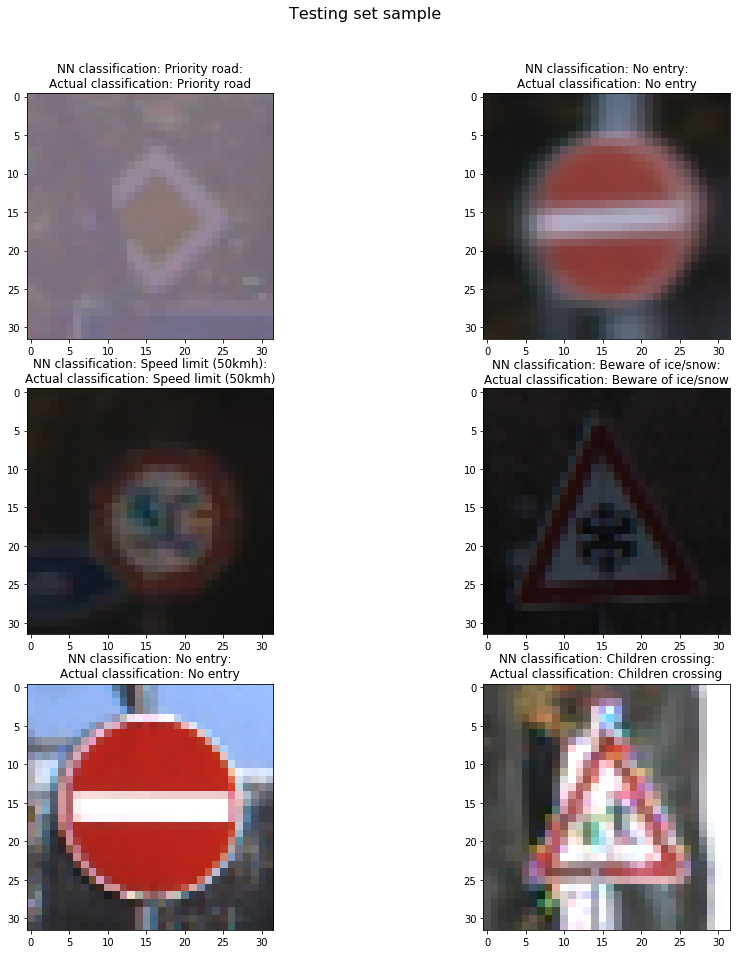

In [19]:
#evaluate and plot random plots of the training set
import random
import numpy as np
import matplotlib.pyplot as plt
import math 

n_visualize = 6 #number of images to be plotted
n_columns = 2 #number of columns in the figure
n_rows = math.ceil(n_visualize/n_columns) #number of rows in the figure

plt.figure(figsize=(15,15))
plt.suptitle('Testing set sample', fontsize=16)

for i in range(n_visualize):
    #obtain random images from test set
    index = random.randint(0,len(X_test))
    test_img, test_img_n, test_label = X_test[index], X_test_n[index], y_test[index]
 
    #evaluate selected image  
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, tf.train.latest_checkpoint('model')) 
        
        graph = tf.get_default_graph()
        x = graph.get_tensor_by_name('placeholder_x:0') 
        keep_prob = graph.get_tensor_by_name('keep_prob:0')
        logits = graph.get_tensor_by_name('logits_out:0')
        
        output = sess.run(logits, feed_dict={x: [test_img_n], keep_prob: 1})
        
    #Analyzing result
    output = np.argmax(output)
    output_msg = signnameslist[output]
    actual_msg = signnameslist[test_label]
    
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(X_test[index])
    plt.title((('NN classification: {}:'.format(output_msg) + '\n' + 'Actual classification: {}'.format(actual_msg))))

plt.subplots_adjust(top=0.9)
plt.savefig('writeup_images/testing_set_sample.jpg')
plt.show()

---

## Step 3: Test the Model on New Images

To provide more insight into how the model is working, several pictures of German traffic signs from the web are used to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

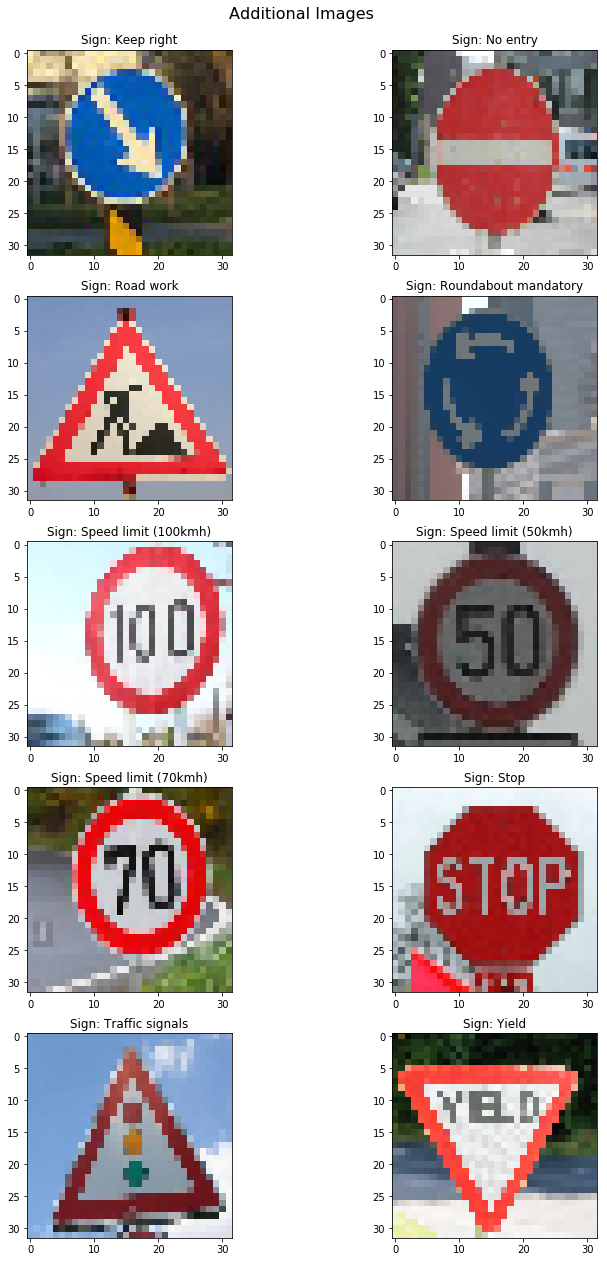

In [20]:
from run import load_images
import matplotlib.pyplot as plt
import math

test_img_dir = "test_images/"

imgs, files = load_images(test_img_dir)

n_imgs = len(files) #number of images in file
n_columns = 2 #number of columns in the figure
n_rows = math.ceil(n_imgs/n_columns) #number of rows in the figure

plt.figure(figsize=(6*n_columns,4*n_rows))
plt.suptitle('Additional Images', fontsize=16)

#show testing images
for i in range(len(imgs)):  
    
    #outputing images
    img = imgs[i]
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(img)
    plt.title('Sign: ' + files[i][:-4]) #the name of each image is it's meaning (removing .jpg)

plt.subplots_adjust(top=0.95)
plt.savefig('writeup_images/additional_images.jpg')
plt.show()

### Predict the Sign Type for Each Image

In [21]:
from run import NN_run, classify

#run the NN on test images
output = NN_run(imgs)
output_msg = classify(output)

INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet


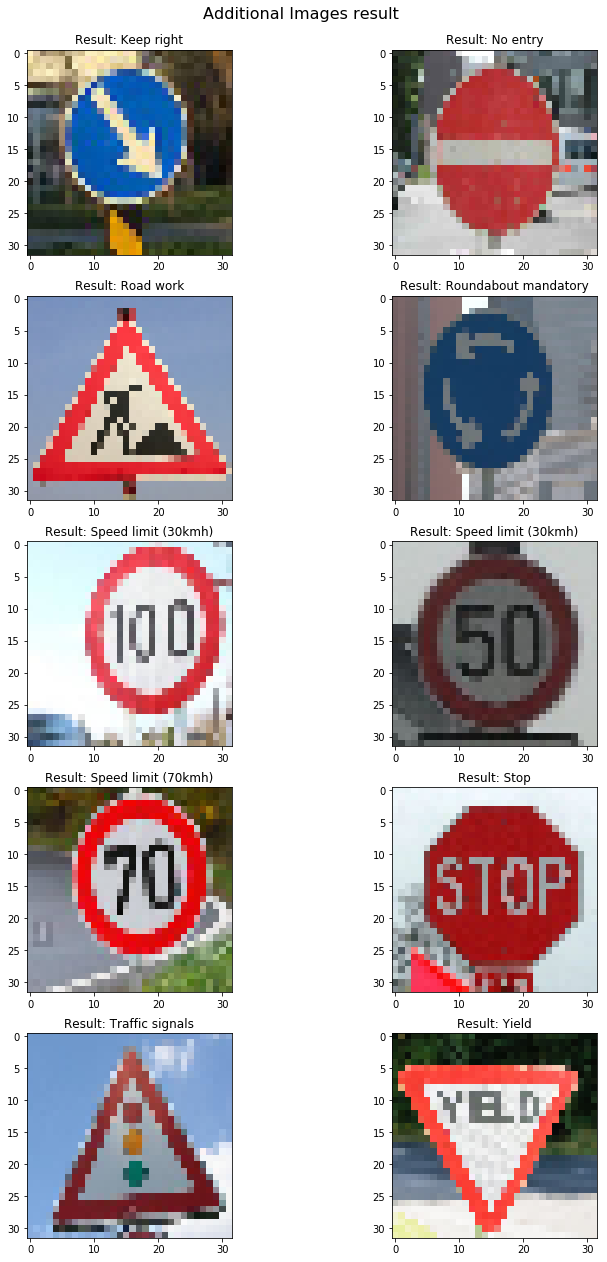

In [22]:
#visualizing results

plt.figure(figsize=(6*n_columns,4*n_rows))
plt.suptitle('Additional Images result', fontsize=16)

for i in range(n_imgs):
    #obtain random images from test set
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(imgs[i])
    plt.title("Result: {}".format(output_msg[i]))

plt.subplots_adjust(top=0.95)
plt.savefig('writeup_images/additional_images_result.jpg')
plt.show()

### Analyze Performance

In [23]:
### Calculate the accuracy for the new images. 
import re

#Calculating number of correct outputs
correct = 0
for i in range(n_imgs):
    prediction = re.sub('/', '', output_msg[i])
    actual = files[i][:-4] 
    if (prediction.upper() == actual.upper()):
        correct = correct + 1

accuracy = (correct / n_imgs) * 100
print('The accuracy of the prediction of the additional images is: {}%'.format(accuracy))

The accuracy of the prediction of the additional images is: 80.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, the model's softmax probabilities are printed out to show the **certainty** of the model's predictions (output is limited to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) is used for this purpose. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

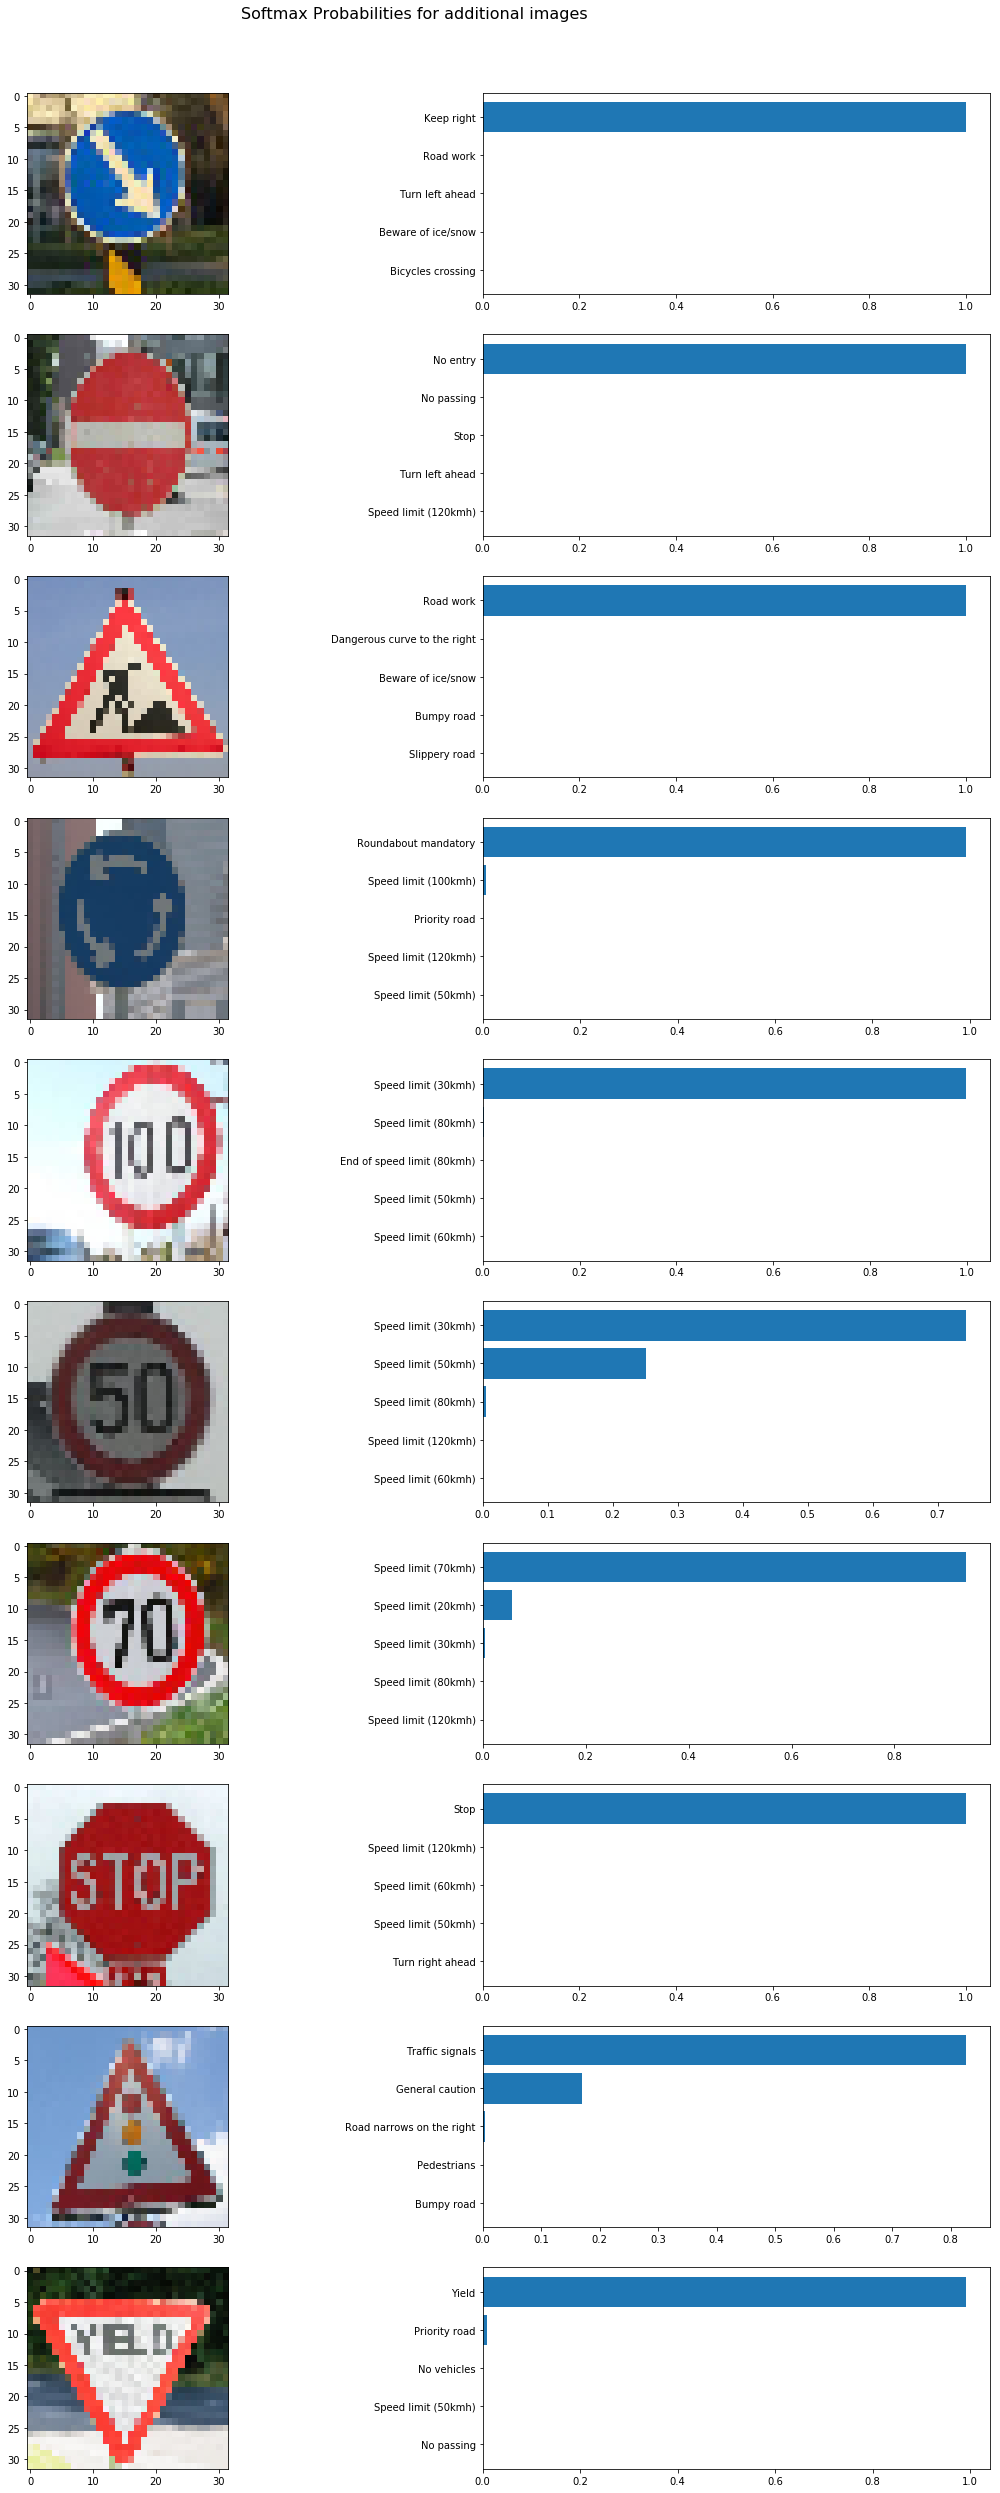

In [24]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

#obtaining the softmax probabolties
with tf.Session() as sess:
    top_output = sess.run(tf.nn.top_k(tf.nn.softmax(output), k=5))

plt.figure(figsize=(20,4*n_imgs))
plt.suptitle('Softmax Probabilities for additional images', fontsize=16)

#displaying the softmax probabilties for all images
for i in range(0,len(top_output[0])):
    #print('The top 5 softmax probabilities for image: {}  are: {}'.format(i+1, top_output[0][i]))
    output_msgs =[]
    for output_msg in top_output[1][i]:
        output_msgs.append(signnameslist[output_msg])
    #print('The corresponding messages for image {}: are: {}'.format(i+1, output_msgs))
    plt.subplot(n_imgs, 2, (2*i)+1)
    plt.imshow(imgs[i])
    plt.subplot(n_imgs, 2, (2*i)+2)
    #print(len(top_output[0][i]))
    plt.barh(range(5), top_output[0][i])
    plt.yticks(range(5), output_msgs)
    plt.gca().invert_yaxis()

plt.subplots_adjust(top=0.95)
plt.savefig('writeup_images/softmax_probabilities.jpg')
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="writeup_images/visualizeCNN.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [25]:
### Visualize your network's feature maps here.
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x: image_input, keep_prob: 1})
    print(activation.shape)
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(40,40))
    for featuremap in range(featuremaps):
        plt.subplot(10,7, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

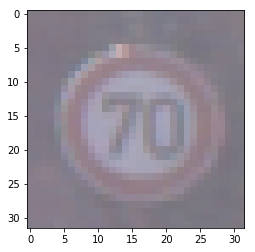

In [26]:
#selecting and showing an image
import random

index = random.randint(0,n_train)
trial_image = X_train[index]
trial_image_n = X_train_n[index]

plt.imshow(trial_image)
plt.savefig('writeup_images/vis_sample_img.jpg')
plt.show()

INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
(1, 28, 28, 30)


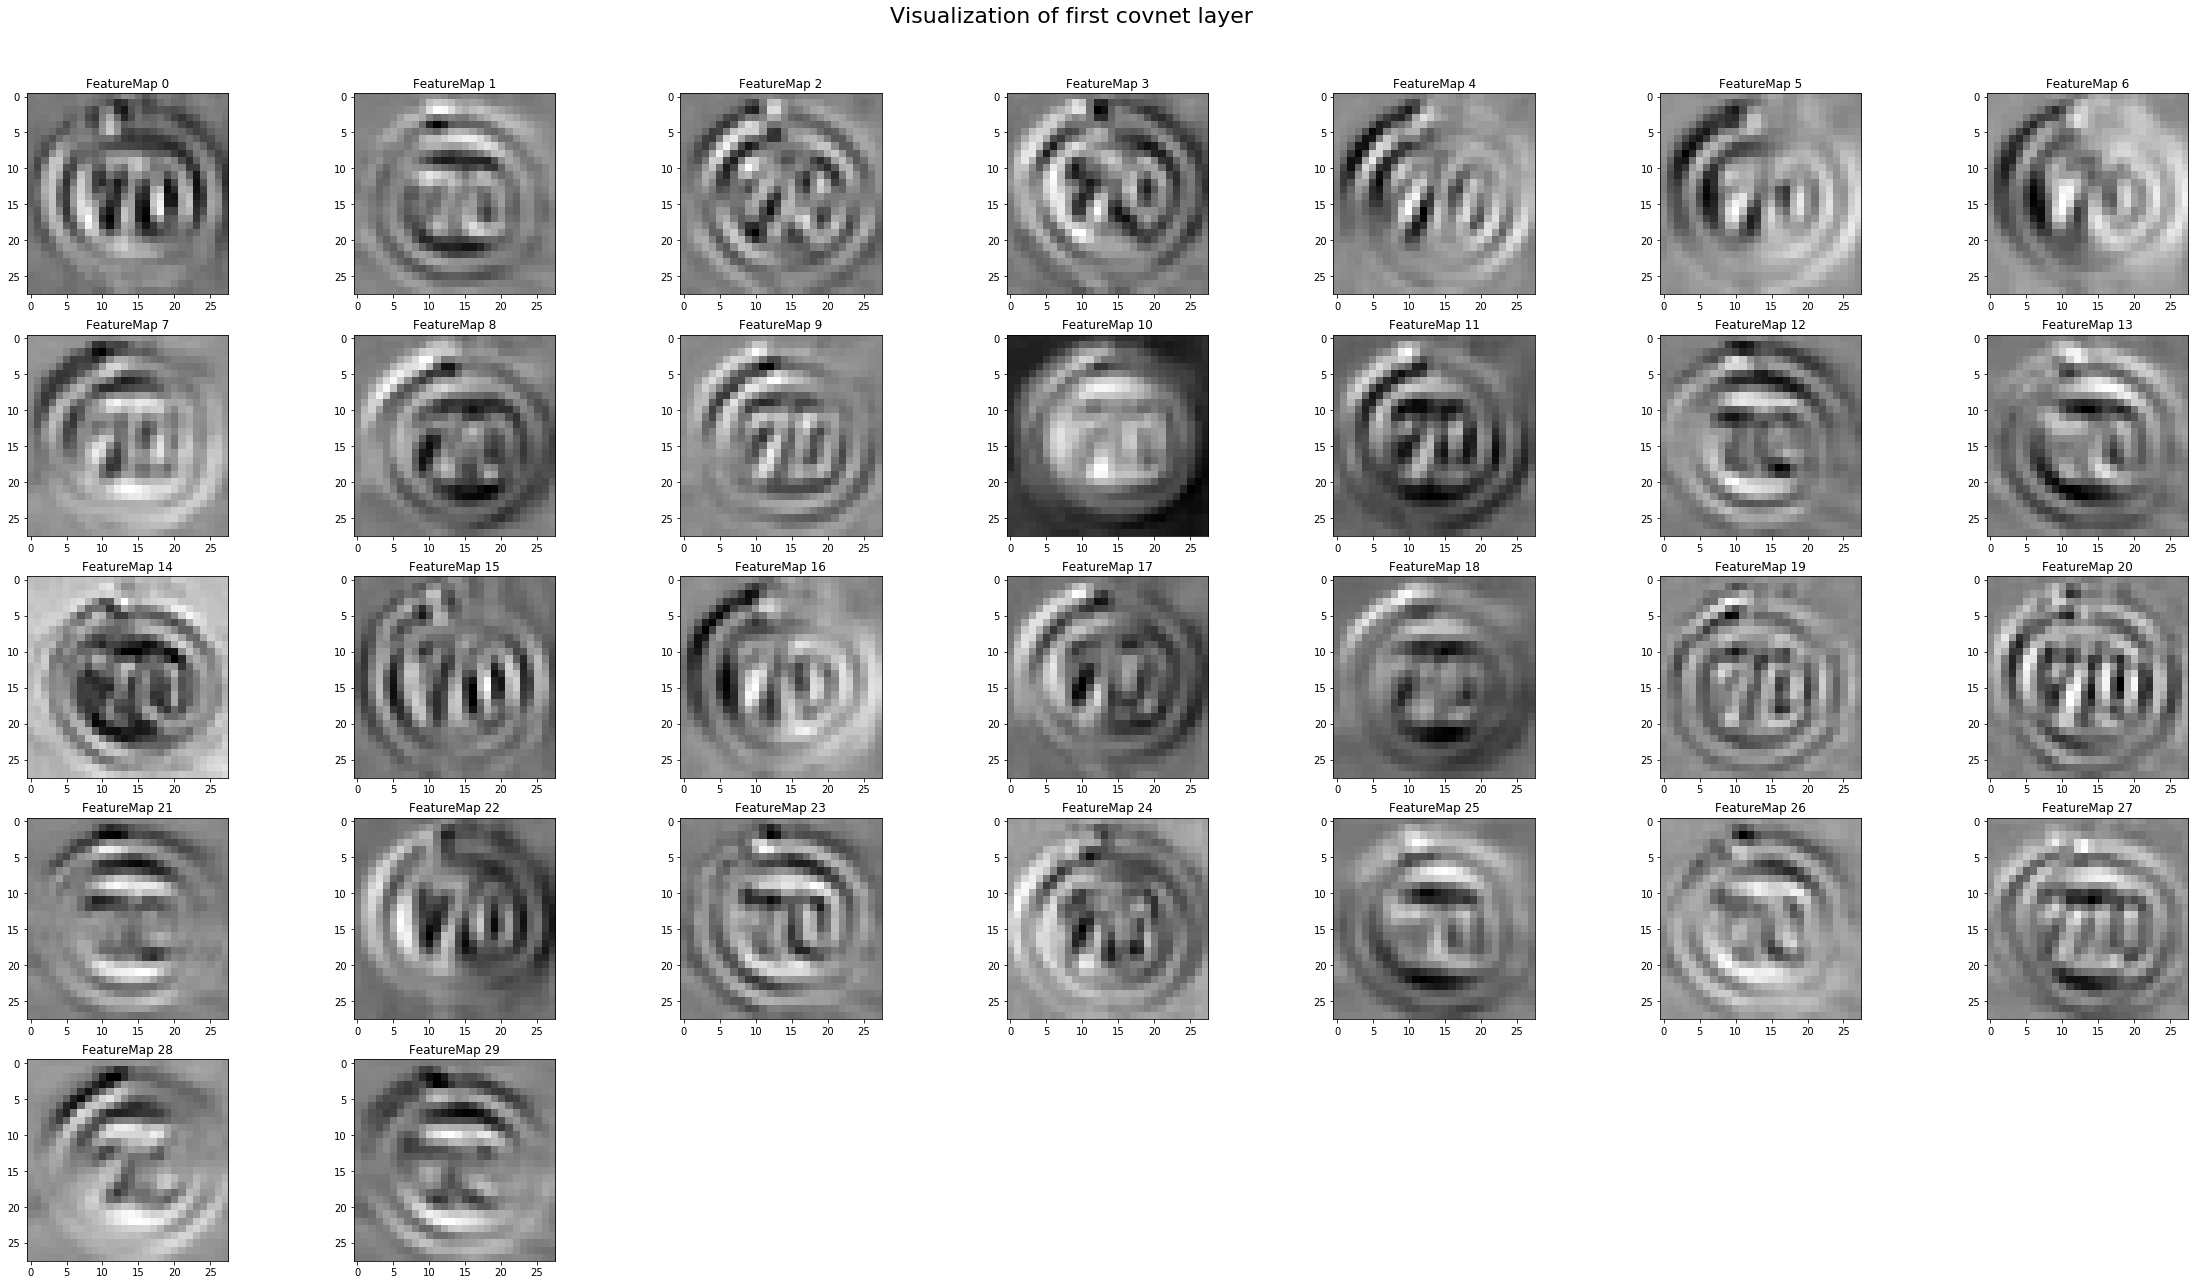

In [28]:
#Visualizing first convolutional layer

with tf.Session() as sess:
    # Convolution (layer 1 after 'tf.nn.conv2d' operation)
    saver = tf.train.import_meta_graph(model_meta) 
    saver.restore(sess, tf.train.latest_checkpoint('model'))
    conv1 = sess.graph.get_tensor_by_name('s2_Covnet-out_layer1:0')
    outputFeatureMap([trial_image_n], conv1)
    plt.suptitle('Visualization of first covnet layer', fontsize=22)
    plt.subplots_adjust(top=0.95)
    plt.savefig('writeup_images/first_covnet_layer')
    plt.show()

INFO:tensorflow:Restoring parameters from model\Traffic_Sign_Classifier_LeNet
(1, 10, 10, 64)


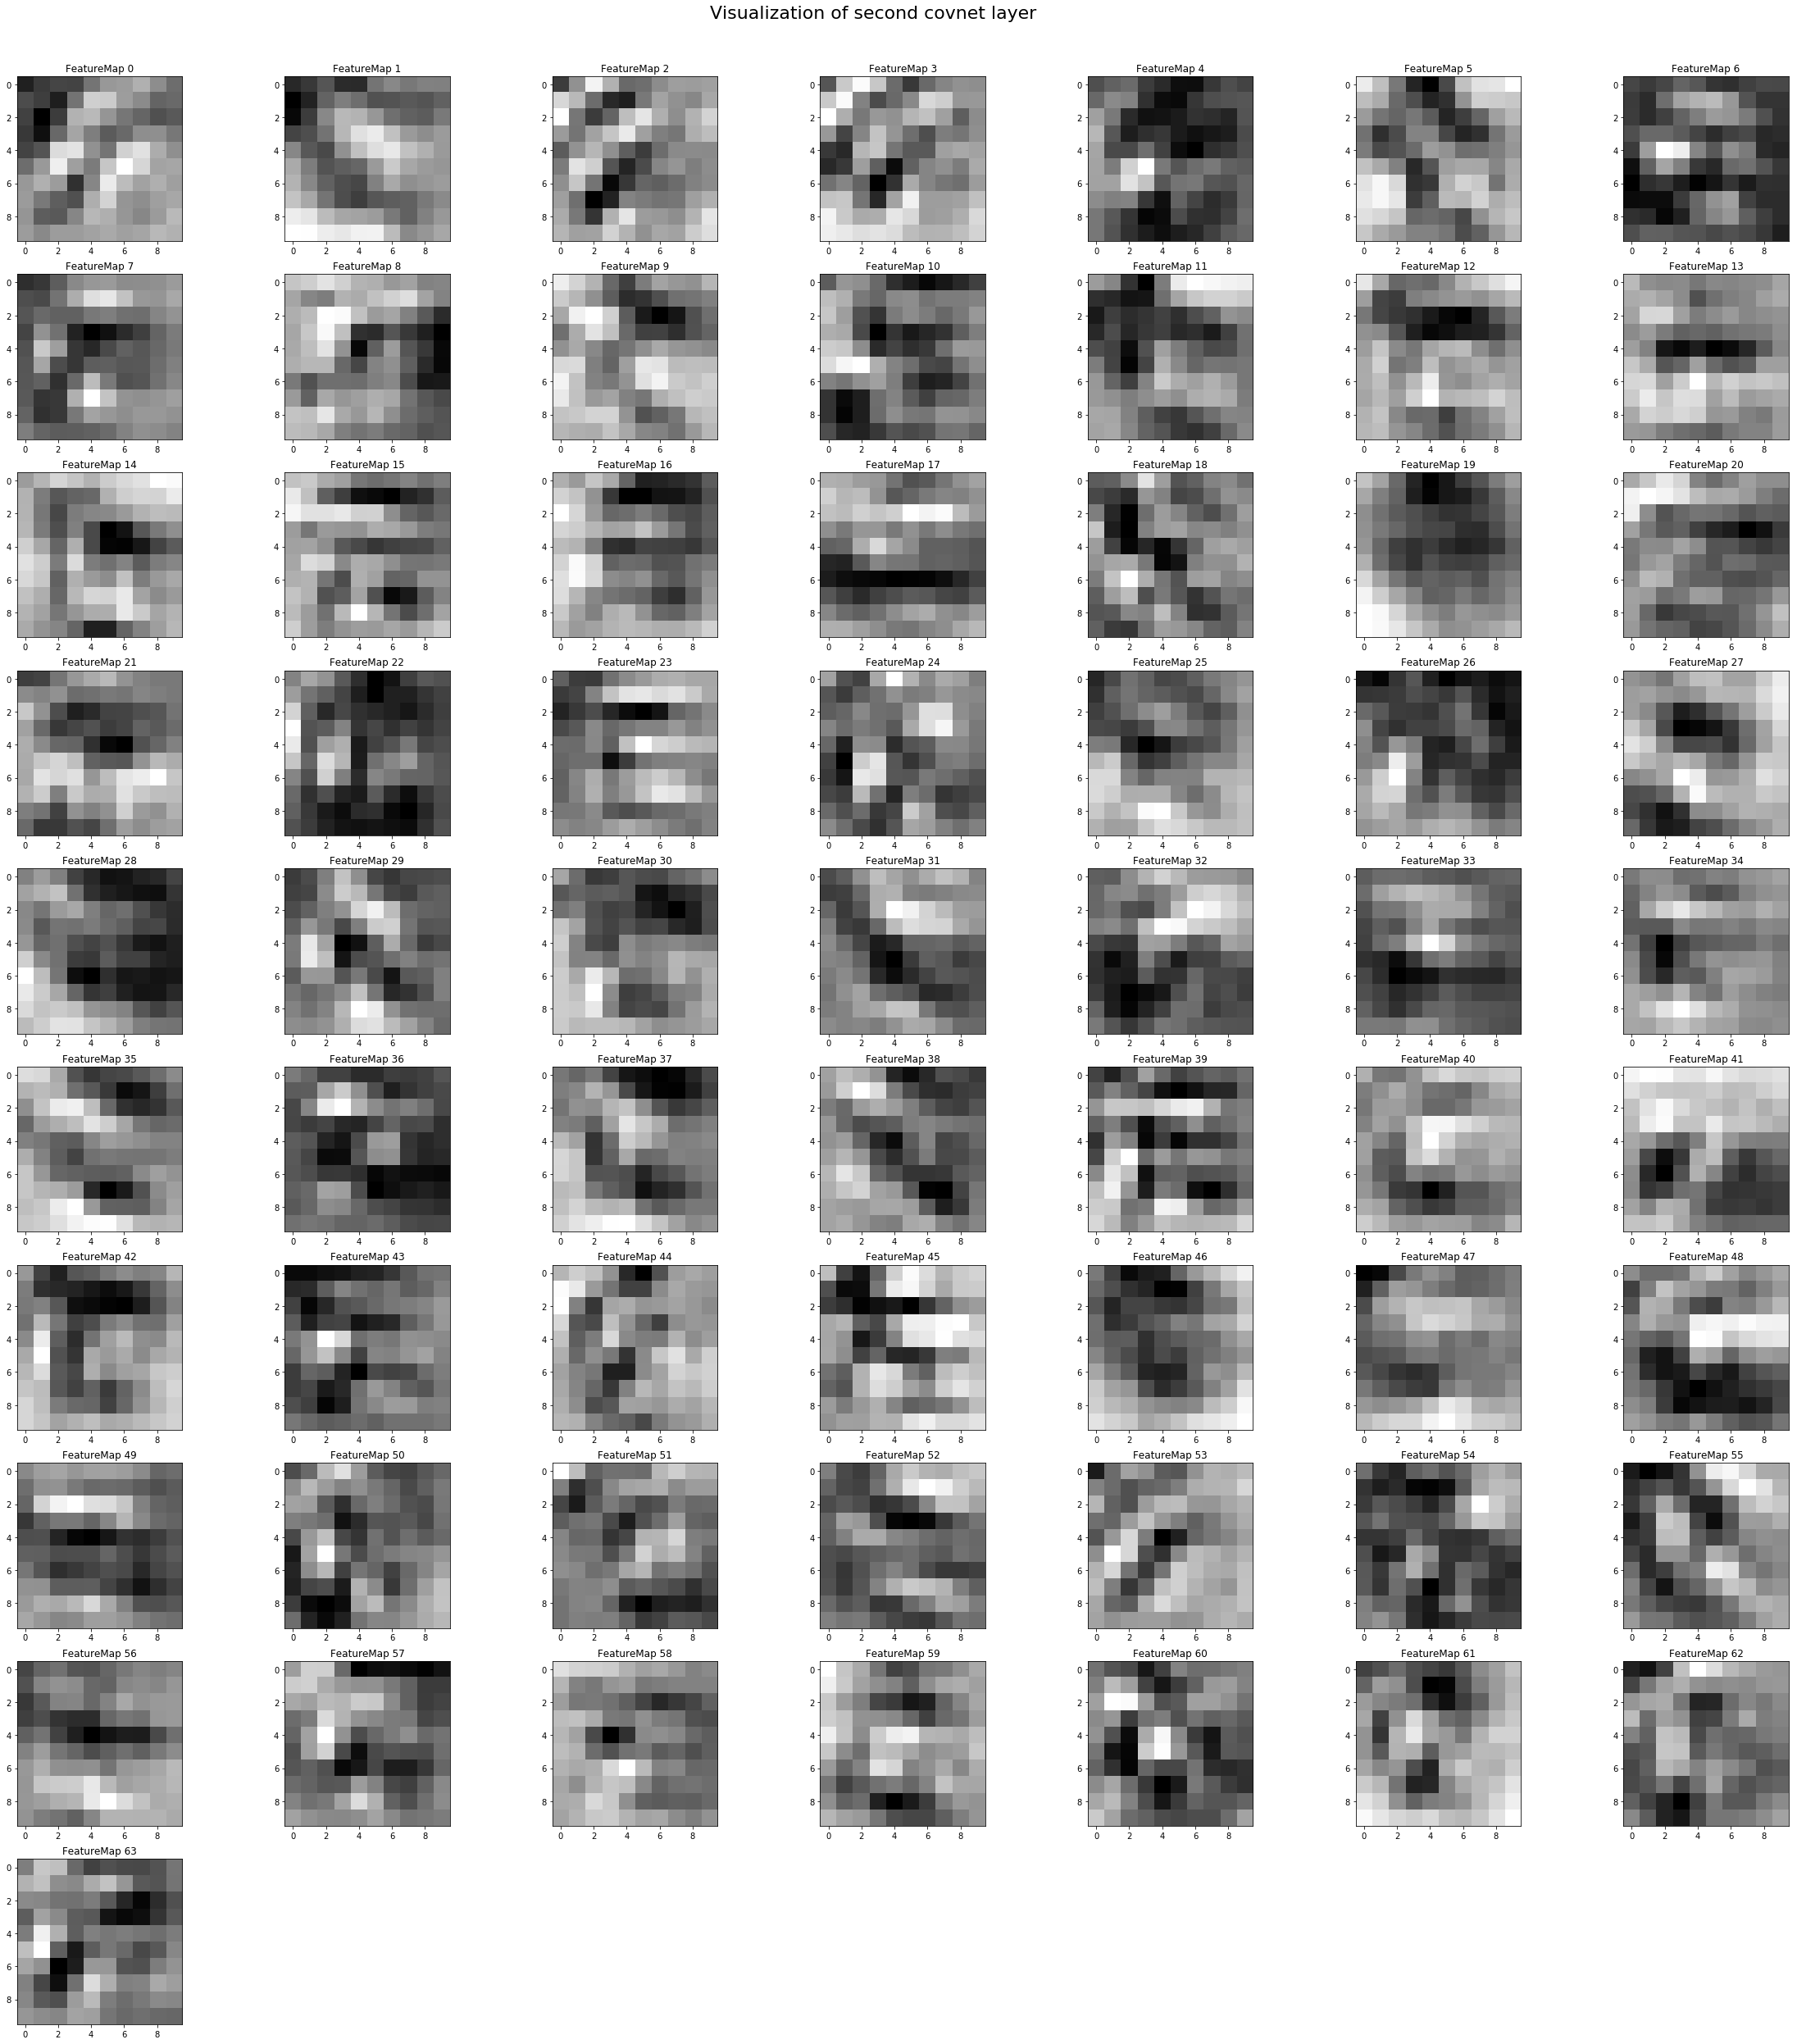

In [29]:
#Visualizing second convolutional layer
with tf.Session() as sess:
    # Convolution (layer 1 after 'tf.nn.conv2d' operation)
    saver = tf.train.import_meta_graph(model_meta) 
    saver.restore(sess, tf.train.latest_checkpoint('model'))
    conv1 = sess.graph.get_tensor_by_name('s2_Covnet-out_layer2:0')
    outputFeatureMap([trial_image_n], conv1)
    plt.suptitle('Visualization of second covnet layer', fontsize=22)
    plt.subplots_adjust(top=0.95)
    plt.savefig('writeup_images/second_covnet_layer')
    plt.show()